## Exploring the Results from Cloud Vision

#### Import statements

In [102]:
import matplotlib
import matplotlib.pylab as plt
import pandas as pd
import json
import os
import sys
import random
import statistics
from PIL import Image
import PIL

In [2]:

dataset_dir = os.path.expanduser("~") + "/datasets/handwriting/IAM_Handwriting_Top50/"
images_dir = dataset_dir + "data_subset/"
analysis_dir = dataset_dir + "gcloud_analysis/"

fullTextAnnotationDict = {}

for filename in os.listdir(analysis_dir):
    f = os.path.join(analysis_dir, filename)
    
    with open(f, encoding='utf-8', errors='ignore') as file: 
        try :
            js = json.load(file)
            
            fullTextAnnotationDict[filename] = js['responses'][0]['fullTextAnnotation']
        except:
            print("Error processing: ", filename)

Error processing:  m06-031-s02-00.json
Error processing:  a01-058u-s01-00.json
Error processing:  r06-097-s03-01.json
Error processing:  .DS_Store
Error processing:  c03-087b-s00-01.json
Error processing:  m06-031-s03-00.json
Error processing:  g06-011n-s01-03.json
Error processing:  n06-123-s03-00.json
Error processing:  d06-050-s03-00.json
Error processing:  a06-134-s01-00.json
Error processing:  g06-042i-s01-00.json
Error processing:  g06-011l-s01-00.json
Error processing:  a01-058u-s03-00.json
Error processing:  d06-063-s00-02.json
Error processing:  p03-112-s05-00.json
Error processing:  g06-011n-s04-02.json
Error processing:  j06-008-s02-00.json
Error processing:  g06-042g-s01-00.json
Error processing:  c03-003f-s02-00.json
Error processing:  g06-089-s02-03.json
Error processing:  g06-018c-s01-00.json
Error processing:  m06-031-s04-00.json
Error processing:  n06-163-s02-00.json
Error processing:  c03-087a-s01-03.json
Error processing:  g06-050n-s02-00.json
Error processing:  g06-

In [3]:
len(fullTextAnnotationDict)

4866

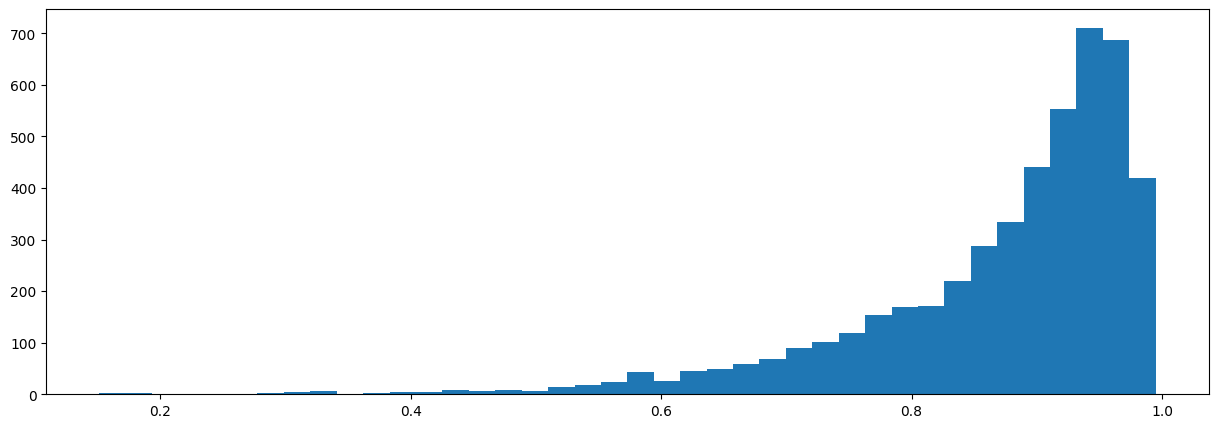

In [4]:
# For the IAM top 50, the dataset was curated for only one page per image
confidence = [x['pages'][0]['confidence'] for x in fullTextAnnotationDict.values()]
cpd = pd.DataFrame(confidence)
# print(len(confidence))
plt.figure(figsize=(15, 5))
plt.hist(cpd.values, bins=40)
plt.show()

#### Get the confidence Levels Per Author

In [6]:
img_author = {}
authors = {}
author_errors = {}
from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))
# forms = pd.read_csv('../input/iam-handwriting-top50/forms_for_parsing.txt', header=None)
# print(forms.head)
with open(dataset_dir + '/forms_for_parsing.txt') as f:
    for line in f:
        key = line.split(' ')[0]
        writer = line.split(' ')[1]
        img_author[key] = writer
        if writer not in authors:
            authors[writer] = []
            author_errors[writer] = []
        authors[writer].append(key)
print("# Authors: ", len(authors.keys()))
print("# Images: ", len(img_author.keys())) # Images are segmented

# Authors:  657
# Images:  1539


Define helper functions to be used while processing

In [8]:
def getFilenameKey(filename: str):
    return '-'.join(filename.split("-")[0:2])

#### Show the error rates per author

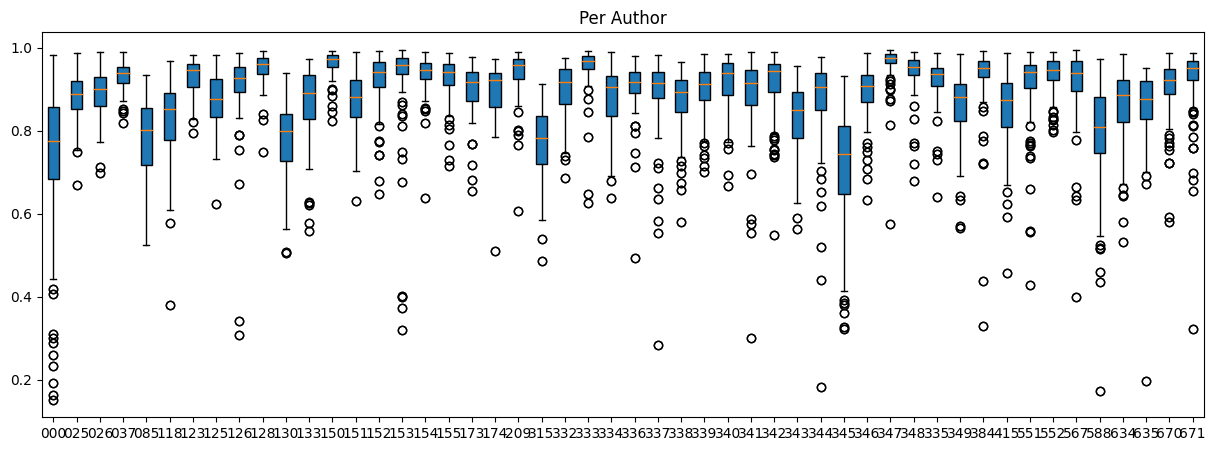

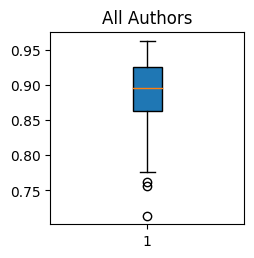

In [9]:
# Create dictionaries
for filename, json_resp in fullTextAnnotationDict.items():
    fn_key = getFilenameKey(filename)
    author = img_author[fn_key]
    confidence = json_resp['pages'][0]['confidence']
    author_errors[str(author)].append(confidence)

author_errors_filtered = { k:v for (k,v) in author_errors.items() if len(v) > 0 }

# Box Plot Per Author
plt.figure(figsize=(15, 5))
plt.title("Per Author")
plt.boxplot(author_errors_filtered.values(), vert=True, patch_artist=True)
plt.xticks(range(1, len(author_errors_filtered.keys()) + 1), author_errors_filtered.keys())
plt.show()

# Average over all authors
plt.figure(figsize=(2.5, 2.5))
plt.title("All Authors")
author_normalized_errors = {k: statistics.mean(v) for k, v in author_errors_filtered.items()}
plt.boxplot(author_normalized_errors.values(), vert=True, patch_artist=True)
plt.show()

According to the chart above the approximate mean error for all authors is ~0.90 with an upper IQR of ~0.92.

#### Filter Outliers & Inaccurate Data

In [85]:
# Filter all with < .85 confidence and is English
max_alpha = 0.15
high_confidence_analyses = {}
texts = []

def isascii(s):
    """Check if the characters in string s are in ASCII, U+0-U+7F."""
    return len(s) == len(s.encode())

for filename, json_resp in fullTextAnnotationDict.items():
    language = None
    confidence = 0.0
    text = None
    try:
        fn_key = getFilenameKey(filename)
        author = img_author[fn_key]
        confidence = json_resp['pages'][0]['confidence']
        language   = json_resp['pages'][0]['property']['detectedLanguages'][0]['languageCode']
        text       = json_resp['text']
        # print(language)
    except:
        language = None
        text = None
        # print("Error: ", json_resp)
    
    if (1 - confidence) < max_alpha and language == "en" and text and isascii(text):
        texts.append(text)
        high_confidence_analyses[filename] = json_resp

print("# High Confidence Images: ", len(high_confidence_analyses.keys()))


# High Confidence Images:  3152


##### Remaining

Style Transfer Between Two Authors
- Group Letters
- Standardize Image Size
- Find Similarities


Write Up

#### Image saving helper functions

In [104]:
def getBoundingBox(symbols):
    boundingBox = None
    if len(symbols) == 1:
        vertices = symbols[0]['boundingBox']['vertices']
        boundingBox = (
            vertices[0].get('x', 0),
            vertices[0].get('y', 0),
            vertices[1].get('x', 0),
            vertices[2].get('y', 0)
        )
    else: # TODO - this should be made dynamic and support > 2 chars
        vertices1 = symbols[0]['boundingBox']['vertices']
        vertices2 = symbols[1]['boundingBox']['vertices']
        boundingBox = (
            vertices1[0].get('x', 0),
            vertices1[0].get('y', 0) if vertices1[0].get('y', sys.maxsize) < vertices2[0].get('y', sys.maxsize) else vertices1[0].get('y', 0),
            vertices2[1].get('x', 0),
            vertices1[2].get('y', 0) if vertices1[2].get('y', 0) > vertices2[0].get('y', 0) else vertices2[0].get('y', 0)
        )
    # Cloud Vision will return < 0 if it thinks the char starts "off" the image
    return tuple(0 if x < 0 else x for x in boundingBox)

def string_to_hex(s):
    return s.encode('utf-8').hex()

def hex_to_string(h):
    return bytes.fromhex(h).decode('utf-8')

def getLetters(symbols):
    if len(symbols) == 1:
        return symbols[0]['text']
    else:
        return symbols[0]['text'] + symbols[1]['text']

def cropImage(pil_image, bounding_box):
    return pil_image.crop(bounding_box)
    
def resizeImage(pil_image, x_px, y_px):
    return pil_image.thumbnail((x_px, y_px), PIL.Image.LANCZOS)

def saveImage(pil_image, chars_str, image_path, filename):
    rand_v = str(random.randint(1, 1000000000))
    chars_hash = string_to_hex(chars_str)
    img_path = image_path + chars_hash + "/"
    
    if not os.path.exists(img_path):
       os.makedirs(img_path)
    
    full_path = img_path + filename.replace('.json', '') + "-" + rand_v + '.png'
    # print(full_path)
    pil_image.save(full_path)

In [105]:
# Todo: Parallelize

updated_image_size_x = 56
updated_image_size_y = 56
crop_dir = dataset_dir + 'cropped/'
std_img_dir = crop_dir + 'std/'
resize_img_dir = crop_dir + 'resized/'

for filename, json_resp in high_confidence_analyses.items():
    fn_key = getFilenameKey(filename)
    author = img_author[fn_key]
    x = 0
    blocks = []
    # max_letter_set_length = 2 # TODO allow for more than 2 letters in a row
    unmanipulated_image = Image.open(images_dir + filename.replace('json', 'png'))
    for block in json_resp['pages'][0]['blocks']:
        if block['blockType'] != "TEXT":
            print("Non-text block type detected: ", block['type'])
            continue
        for paragraph in block["paragraphs"]:
            for word in paragraph["words"]:
                previous_symbols = []
                for symbol in word["symbols"]:
                    previous_symbols.append(symbol)

                    # Single character:
                    single_symbol = [symbol]
                    bb = getBoundingBox(single_symbol)
                    chars = getLetters(single_symbol)
                    
                    std_image = cropImage(unmanipulated_image, bb)
                    saveImage(std_image, chars, std_img_dir, filename)
                    
                    rsz_image = resizeImage(std_image, updated_image_size_x, updated_image_size_y)
                    saveImage(rsz_image, chars, resize_img_dir, filename)
                    
                    
                    # Two chars
                    psl = len(previous_symbols)
                    previous_symbol = previous_symbols[psl-2] if psl > 1 else None
                    if previous_symbol != None:
                        symbols = [previous_symbol, symbol]
                        bb = getBoundingBox(symbols)
                        chars = getLetters(symbols)
                        
                        # Standard image
                        std_image = cropImage(unmanipulated_image, bb)
                        saveImage(std_image, chars, std_img_dir, filename)
                    
                        # Thumbnailed/downsampled image
                        rsz_image = resizeImage(std_image, updated_image_size_x, updated_image_size_y)
                        saveImage(rsz_image, chars, resize_img_dir, filename)
                        
                        
                        
print(charsSet)

AttributeError: 'NoneType' object has no attribute 'save'

In [90]:

# Example usage:
s = "Hello, World!"
h = string_to_hex(s)
print(f"String to Hex: {h}")

back_to_string = hex_to_string(h)
print(f"Hex to String: {back_to_string}")

String to Hex: 48656c6c6f2c20576f726c6421
Hex to String: Hello, World!
